In [1]:
import torch
import numpy as np
from shapely.plotting import plot_polygon

import matplotlib.pyplot as plt
import matplotlib.style as style

style.use(
    "https://raw.githubusercontent.com/dominik-strutz/dotfiles/main/mystyle.mplstyle"
)
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Cmap with only blue and deacreasig alpha
blue_cmap = LinearSegmentedColormap.from_list(
    "mycmap",
    [
        "cornflowerblue",
        "mediumblue",
    ],
)
blue_cmap = blue_cmap(np.arange(blue_cmap.N))
blue_cmap[:, -1] = np.linspace(0, 1, blue_cmap.shape[0]) * 0.7
# blue_cmap[:, :3] = [0.0, 0.0, 1.0]
blue_cmap = ListedColormap(blue_cmap)

red_cmap = LinearSegmentedColormap.from_list(
    "mycmap",
    [
        "salmon",
        "firebrick",
    ],
)
red_cmap = red_cmap(np.arange(red_cmap.N))
red_cmap[:, -1] = np.linspace(0, 1, red_cmap.shape[0]) * 1.0
# red_cmap[:, :3] = [1.0, 0.0, 0.0]
red_cmap = ListedColormap(red_cmap)

In [2]:
from dased.layout import DASLayout
from dased.optimisation import DASOptimizationProblem, DASArchipelago

In [3]:
from cdv_setup import (
    topo_data,
    prior_dist,
    prior_grid,
    test_geometry,
    design_space_full,
    x,
    y,
    obstacles,
    full_area,
    tomo_roi,
    existing_geometry,
)

# Source Location

In [4]:
from dased.helpers.srcloc import (
    MagnitudeRelation,
    ForwardHomogeneous,
    DataLikelihood,
)

from dased.criteria import (
    EIGCriterion,
)

In [5]:
reference_distance_loc = 1000.0

f_max = 10.0  # Hz

# Magnitude relations for P and S waves
distance_relation_P = MagnitudeRelation(
    log_coeff=-2,
    reference_distance=reference_distance_loc,
)
distance_relation_S = MagnitudeRelation(
    log_coeff=-2, reference_relation=distance_relation_P
)

# Forward models for P and S waves
forward_function_P = ForwardHomogeneous(
    velocity=2500,
    wave_type="P",
    distance_relation=distance_relation_P,
    incidence_max=np.deg2rad(30),
)
forward_function_S = ForwardHomogeneous(
    velocity=1500,
    wave_type="S",
    distance_relation=distance_relation_S,
    incidence_max=np.deg2rad(30),
)

std_corr=0.05
std_uncorr=0.05

# Data likelihoods for P, S, and joint PS
data_likelihood_P = DataLikelihood(
    forward_function=dict(P=forward_function_P),
    std_corr=std_corr,
    std_uncorr=std_uncorr,
    # cor_length=100.0,
    f_max=f_max,
)
data_likelihood_S = DataLikelihood(
    forward_function=dict(S=forward_function_S),
    std_corr=std_corr,
    std_uncorr=std_uncorr,
    # cor_length=100.0,
    f_max=f_max,
)
data_likelihood_PS = DataLikelihood(
    forward_function=dict(P=forward_function_P, S=forward_function_S),
    std_corr=std_corr,
    std_uncorr=std_uncorr,
    # cor_length=100.0,
    f_max=f_max,
)

torch.manual_seed(0)  # For reproducibility
prior_samples = prior_dist.sample((10000,))


eig_p = EIGCriterion(
    prior_samples[:1000],
    data_likelihood=data_likelihood_P,
    eig_method="NMC",
    N=1000,
    downsample=10,
)
eig_s = EIGCriterion(
    prior_samples[:1000],
    data_likelihood=data_likelihood_S,
    eig_method="NMC",
    N=1000,
    downsample=10,
)
eig_ps = EIGCriterion(
    prior_samples[:1000],
    data_likelihood=data_likelihood_PS,
    eig_method="NMC",
    N=1000,
    downsample=10,
)

In [6]:
cable_properties = {
    "elevation": topo_data,
    "cable_length": 1700,
    "spacing": 10, #downsampled later
    "fixed_points": np.array([[1570, 1330]]),
    "N_knots": 12,
    "k": 1,
    "signal_decay": 0.4,
}

optimisation_properties_p = {
    "bounds": [
        [design_space_full.bounds[0], design_space_full.bounds[2]],
        [design_space_full.bounds[1], design_space_full.bounds[3]],
    ],
    "spatial_constraints": design_space_full.envelope.difference(design_space_full),
}

In [7]:
test_cable_p = DASLayout(
    test_geometry, spacing=cable_properties["spacing"], k=1, elevation=topo_data
)
existing_cable = DASLayout(
    existing_geometry, spacing=cable_properties["spacing"], k=1, elevation=topo_data
)

In [8]:
##############################################################################
##############################################################################
############### THIS HAS TO BE FIRST PLOT IN THE NOTEBOOK
############### OTHERWISE IT WILL NOT WORK, FOR SOME REASON
##############################################################################
##############################################################################

from interactive_proposal import select_points

proposal_points = select_points(
    design_space=design_space_full,
    cable_properties=cable_properties,
    filename="data/optimisation/proposal_points_single_eigp.pkl",
)

##############################################################################
############### IF THIS IS CALLED IT WILL NOT WORK AGAIN
############### BUT IT IS NEEDED TO HAVE LATE PLOTS DISPLAYED
##############################################################################

%matplotlib inline

Loaded precomputed points from data/optimisation/proposal_points_single_eigp.pkl


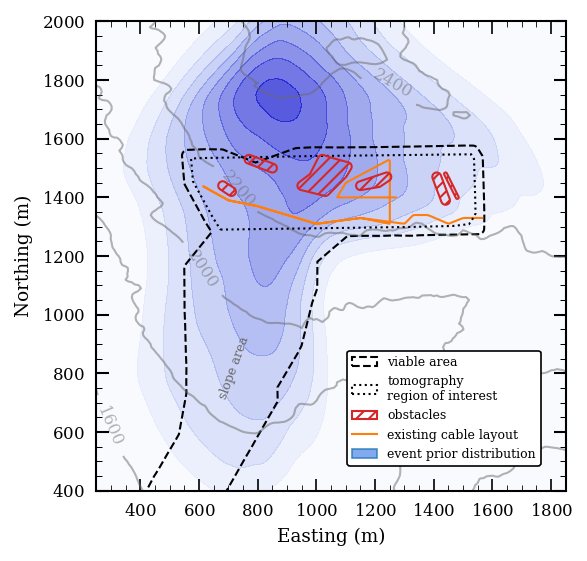

In [9]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# Plot the prior distribution
prior_plot = ax.contourf(
    x,
    y,
    prior_grid.T,
    levels=8,
    cmap=blue_cmap,
    zorder=-1,
)

plot_polygon(
    full_area,
    ax=ax,
    facecolor="none",
    edgecolor="k",
    linestyle="--",
    linewidth=1.0,
    label="viable area",
    add_points=False,
)
# plot_polygon(
#     design_space_full, ax=ax, facecolor='k', edgecolor='k',
#     linestyle='--', linewidth=1.5, alpha=0.1, add_points=False)
plot_polygon(
    tomo_roi,
    ax=ax,
    facecolor="none",
    edgecolor="k",
    hatch_linewidth=1.0,
    linestyle=":",
    linewidth=1.0,
    zorder=10,
    label="tomography\nregion of interest",
    add_points=False,
)
# plot_polygon(
#     shoulder_area, ax=ax, facecolor='k', edgecolor='k',
#     linestyle=':', linewidth=1.5, alpha=0.1, add_points=False)

# ax.plot([], [], color='blue', label='event prior distribution', alpha=0.8)

for i, obstacle in enumerate(obstacles.geoms):
    plot_polygon(
        obstacle,
        ax=ax,
        facecolor="none",
        edgecolor="tab:red",
        linestyle="-",
        linewidth=1.0,
        label="obstacles" if i == 0 else "",
        add_points=False,
        zorder=10,
        hatch="////",
        hatch_linewidth=1.0,
    )

# Plot the topography as a colormapped background
contour = ax.contour(
    topo_data.x,
    topo_data.y,
    topo_data.values.T,
    colors="dimgray",
    alpha=0.5,
    levels=[1600, 1800, 2000, 2200, 2400, 2600],
    linewidths=1.0,
)
ax.clabel(contour, inline=True, fontsize=8, fmt="%1.0f")

ax.set_aspect("equal")
# Customize plot
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")


# text shoulder area
ax.text(
    720,
    820,
    "slope area",
    fontsize=6,
    color="dimgrey",
    rotation=70,
    ha="center",
    va="center",
)

# plot the existing cable layout
existing_cable.plot(
    ax=ax,
    plot_style="line",
    zorder=5,
    color="tab:orange",
    linewidth=1.0,
    linestyle="-",
    label="existing cable layout",
)

prior_handle = plt.Rectangle(
    [0, 0],
    1,
    1,
    facecolor="cornflowerblue",
    edgecolor="tab:blue",
    alpha=0.8,
    label="event prior distribution",
)

ax.add_artist(prior_handle)

ax.legend(loc="lower right", facecolor="white", edgecolor="black", fontsize=6)

fig.savefig("figures/cdv_setup.png", dpi=300, bbox_inches="tight")
fig.savefig("figures/cdv_setup.pdf", dpi=300, bbox_inches="tight")

ax.set_xlim(250, 1850)
ax.set_ylim(400, 2000)

plt.tight_layout()
plt.show()

In [10]:
udp = DASOptimizationProblem(
    eig_p,
    verbose=0,
    **cable_properties,
    **optimisation_properties_p,
)

archipelago = DASArchipelago(udp, n_islands=16, population_size=128, verbose=0)

archipelago.initialize(
    proposal_points=proposal_points,
    perturb_proposal=50.0,
    perturb_knots=25.0,
    corr_len=500,
    corr_str=0.8,
    min_length=1000,
    show_progress=True,
    filename="data/optimisation/initial_population_single_p",
)

Logging level: WARNING


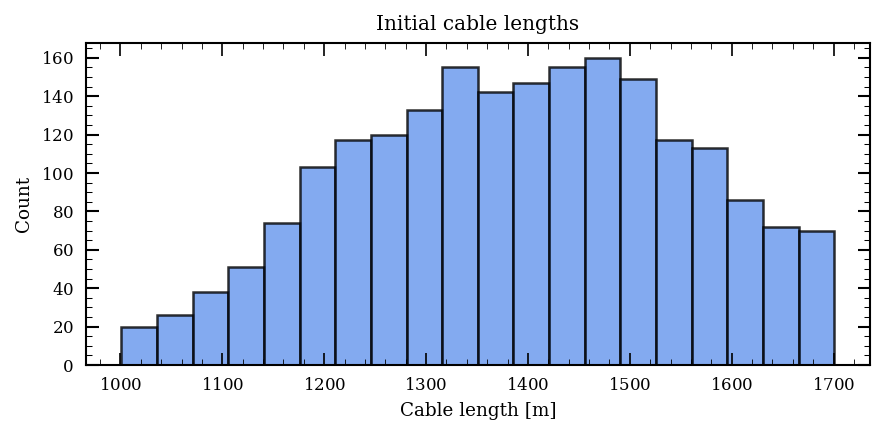

In [11]:
initial_layouts = archipelago.get_current_layouts()

lengths = [_l.cable_length for _l in initial_layouts]

fig, ax = plt.subplots(figsize=(6, 3))

ax.hist(
    lengths,
    bins=20,
    color="cornflowerblue",
    alpha=0.8,
    edgecolor="black",
    linewidth=1.2,
)

ax.set_xlabel("Cable length [m]")
ax.set_ylabel("Count")
ax.set_title("Initial cable lengths")

plt.tight_layout()
plt.show()

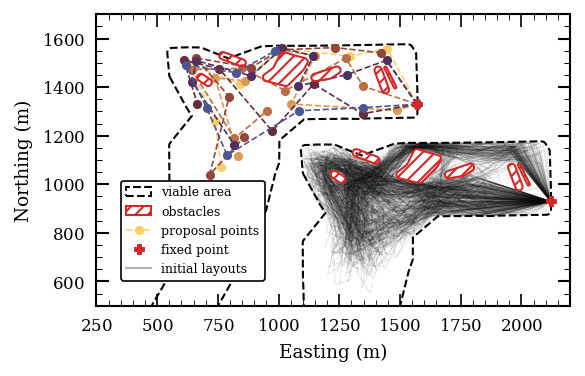

In [12]:
from shapely.affinity import translate

fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

plot_polygon(
    full_area,
    ax=ax,
    facecolor="none",
    edgecolor="k",
    linestyle="--",
    linewidth=1.0,
    label="viable area",
    add_points=False,
)


for i, obstacle in enumerate(obstacles.geoms):
    plot_polygon(
        obstacle,
        ax=ax,
        facecolor="none",
        edgecolor="tab:red",
        linestyle="-",
        linewidth=1.0,
        label="obstacles" if i == 0 else "",
        add_points=False,
        zorder=10,
        hatch="////",
        hatch_linewidth=1.0,
    )

fixed_point = cable_properties["fixed_points"][0]

# Plot proposal points with tab10 colormap
tab10 = plt.get_cmap("managua", 10)  # Use viridis colormap for better visibility
for i, pp in enumerate(proposal_points):
    pp = np.array(pp)
    # Prepend the fixed point as the first point
    pp_with_fixed = np.vstack([fixed_point, pp])
    color = tab10(i % 10)
    ax.plot(
        pp_with_fixed[:, 0],
        pp_with_fixed[:, 1],
        "o--",
        markersize=3,
        color=color,
        linewidth=0.8,
        label="proposal points" if i == 0 else "",
    )

# Plot fixed points
ax.plot(
    fixed_point[0],
    fixed_point[1],
    "P",
    color="tab:red",
    markersize=4,
    label="fixed point",
)
ax.plot(
    fixed_point[0] + 550,
    fixed_point[1] - 400,
    "P",
    color="tab:red",
    markersize=4,
)

# Shift the design space by [100, -100] for illustration

full_area_shifted = translate(full_area, xoff=550, yoff=-400)

plot_polygon(
    full_area_shifted,
    ax=ax,
    facecolor="none",
    edgecolor="k",
    linestyle="--",
    linewidth=1.0,
    add_points=False,
)

# Plot initial layouts
# Select N=500 random initial layouts for plotting
N = 500
if len(initial_layouts) > N:
    idx = np.random.choice(len(initial_layouts), N, replace=False)
    selected_layouts = [initial_layouts[i] for i in idx]
else:
    selected_layouts = initial_layouts

for layout in selected_layouts:
    channels = np.array(layout.channel_locations)
    channels += np.array(
        [550, -400, 0]
    )  # Shift channels by [550, -400] for illustration
    ax.plot(
        channels[:, 0],
        channels[:, 1],
        color="k",
        alpha=0.1,
        linewidth=0.5,
        label="_nolegend_",
        zorder=-10,
        linestyle="-",
    )

ax.plot([], [], color="k", alpha=0.3, linewidth=1.0, label="initial layouts")

for i, obstacle in enumerate(obstacles.geoms):
    obstacle = translate(obstacle, xoff=550, yoff=-400)
    plot_polygon(
        obstacle,
        ax=ax,
        facecolor="none",
        edgecolor="tab:red",
        linestyle="-",
        linewidth=1.0,
        add_points=False,
        zorder=10,
        hatch="////",
        hatch_linewidth=1.0,
    )

ax.set_aspect("equal")

# Move legend below plot
ax.legend(loc="lower left", facecolor="white", edgecolor="black", fontsize=6)


ax.set_xlim(250, 2200)
ax.set_ylim(500, 1700)

# ax.set_xticklabels([])
# ax.set_yticklabels([])
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")

fig.savefig("figures/cdv_initial_layouts.png", dpi=300, bbox_inches="tight")
fig.savefig("figures/cdv_initial_layouts.pdf", dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

In [13]:
archipelago.get_file_info('data/optimisation/optimiser_single_p')

Save file 'data/optimisation/optimiser_single_p.npz' (format v1.0) contains:
- Number of islands: 16
- Population size: 128
- Number of objectives: 1
- Completed generations: 1000
- Algorithms: SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm


"Save file 'data/optimisation/optimiser_single_p.npz' (format v1.0) contains:\n- Number of islands: 16\n- Population size: 128\n- Number of objectives: 1\n- Completed generations: 1000\n- Algorithms: SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm"

In [14]:
print(f"EIG_p (existing cable): {eig_p(existing_cable):.2f}")

EIG_p (existing cable): 4.82


In [15]:
archipelago.optimize(
    n_generations=1000,
    migrate_every=20,
    show_progress=True,
    filename="data/optimisation/optimiser_single_p",
)


Evolving islands: 0it [00:00, ?it/s]

In [16]:
best_layout_p = archipelago.get_best_single()[0]

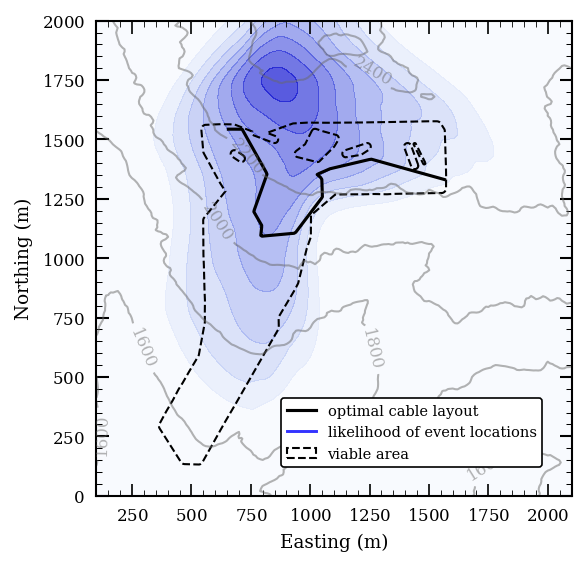

In [17]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# Plot the prior distribution
prior_plot = ax.contourf(
    x,
    y,
    prior_grid.T,
    levels=8,
    cmap=blue_cmap,
    zorder=-1,
)

best_layout_p.plot(
    ax=ax, plot_style="line", color="k", linewidth=1.5, label="optimal cable layout"
)
ax.plot([], [], color="blue", label="likelihood of event locations", alpha=0.8)

plot_polygon(
    design_space_full,
    ax=ax,
    facecolor="none",
    edgecolor="k",
    linestyle="--",
    linewidth=1.0,
    label="viable area",
    add_points=False,
)
# plot_polygon(
#     design_space_full, ax=ax, facecolor='k', edgecolor='k',
#     linestyle='--', linewidth=1.5, alpha=0.1, add_points=False)
# plot_polygon(
#     shoulder_area, ax=ax, facecolor='none', edgecolor='k',
#     linestyle=':', linewidth=1.5, label='shoulder area', add_points=False)
# plot_polygon(
#     shoulder_area, ax=ax, facecolor='k', edgecolor='k',
#     linestyle=':', linewidth=1.5, alpha=0.1, add_points=False)


# Plot the topography as a colormapped background
contour = ax.contour(
    topo_data.x,
    topo_data.y,
    topo_data.values.T,
    colors="dimgray",
    alpha=0.5,
    levels=[1600, 1800, 2000, 2200, 2400, 2600],
    linewidths=1.0,
)
ax.clabel(contour, inline=True, fontsize=8, fmt="%1.0f")

ax.set_aspect("equal")
# Customize plot
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")


ax.legend(loc="lower right", facecolor="white", edgecolor="black", fontsize=7)

plt.tight_layout()
plt.show()

In [18]:
best_layout_p

DASLayout (Local Coords, 166 channels, 13 anchors, spacing≈10.00m, length=1660.70m, decay=0.40 dB/km, 1 field properties)

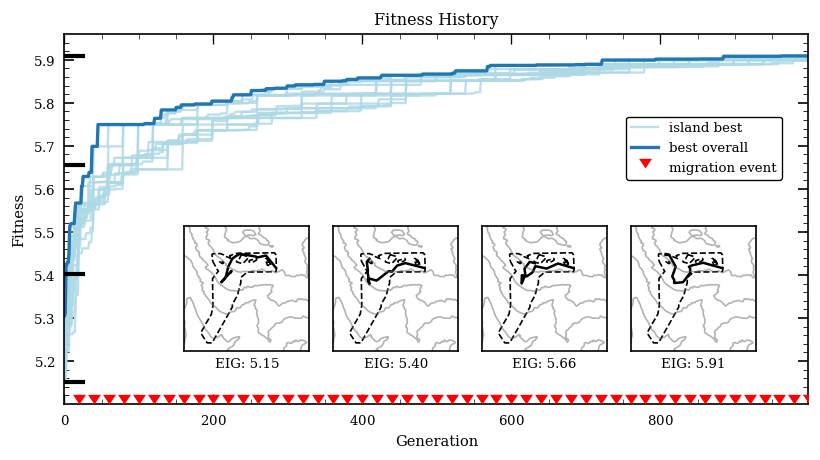

In [19]:
top_layouts, top_fitness = archipelago.get_n_spread_single(4, from_history=True)

fitness_history = archipelago.get_fitness_history()
num_generations = len(fitness_history)

fig = plt.figure(figsize=(8, 4), dpi=120)
gs = fig.add_gridspec(1, 1)
ax_hist = fig.add_subplot(gs[0])
fig.set_facecolor("w")

# fitness_history shape: (n_generations, n_islands)
best_overall = np.max(fitness_history, axis=1)
for i in range(fitness_history.shape[1]):
    ax_hist.plot(
        fitness_history[:, i],
        color="lightblue",
        alpha=0.8,
        label="island best" if i == 0 else None,
    )
ax_hist.plot(best_overall, lw=2, label="best overall", color="tab:blue")

mig_gens = np.arange(
    archipelago.migrate_every, num_generations + 1, archipelago.migrate_every
)
mig_indices = mig_gens[mig_gens <= num_generations]
if mig_indices.size > 0:
    ax_hist.scatter(
        mig_indices,
        [np.min(fitness_history) - 0.05] * len(mig_indices),
        marker=7,
        linewidth=0,
        color="red",
        s=60,
        zorder=5,
        label="migration event",
    )
    ax_hist.set_ylim(bottom=np.min(fitness_history))

ax_hist.set_xlim(left=0, right=num_generations - 1)
ax_hist.set_title("Fitness History")
ax_hist.set_xlabel("Generation")
ax_hist.set_ylabel("Fitness")
ax_hist.legend(loc="upper right", bbox_to_anchor=(1, 0.85))

# Add checkerboard insets, smaller and filling from 0.3 to 1.0 of figure width
inset_width = 0.13
inset_height = 0.3
n_layouts = len(top_layouts)
start = 0.25
end = 1.0
if n_layouts > 1:
    step = (end - start - inset_width) / (n_layouts)
else:
    step = 0
for idx, proposal_layout in enumerate(top_layouts):
    left = start + idx * step
    bottom = 0.2
    ax_inset = fig.add_axes([left, bottom, inset_width, inset_height])
    # criteria_dict['rayleigh_tomo_rer'].plot_checkerboard(
    #     proposal_layout,
    #     sigma_d=1e-2,
    #     correlation_length=200.0,
    #     regularization_weight=1e-5,
    #     ax=ax_inset,
    # )

    proposal_layout.plot(ax=ax_inset, plot_style="line", color="k", linewidth=1.5)
    plot_polygon(
        design_space_full,
        ax=ax_inset,
        facecolor="none",
        edgecolor="k",
        linestyle="--",
        linewidth=1.0,
        label="viable area",
        add_points=False,
    )

    contour = ax_inset.contour(
        topo_data.x,
        topo_data.y,
        topo_data.values.T,
        colors="dimgray",
        alpha=0.5,
        levels=[1600, 1800, 2000, 2200, 2400, 2600],
        linewidths=1.0,
    )

    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    ax_inset.set_aspect("equal")

    ax_inset.set_xlabel(
        f"EIG: {top_fitness[idx]:.2f}",
        fontsize=8,
    )

    ax_hist.axhline(
        top_fitness[idx],
        0,
        0.025,
        color="k",
        linestyle="-",
        linewidth=2.5,
    )

ax_hist.set_ylim(np.min(fitness_history) - 0.05, np.max(fitness_history) + 0.05)

fig.savefig("figures/eig_p_fitness_history.png", bbox_inches="tight", dpi=300)
fig.savefig("figures/eig_p_fitness_history.pdf", bbox_inches="tight", dpi=300)

plt.show()

In [20]:
print(f"EIG_p (existing cable): {eig_p(existing_cable):.2f}")
print(f"EIG_p (test cable): {eig_p(test_cable_p):.2f}")
print(f"EIG_p (best layout): {eig_p(best_layout_p):.2f}")

EIG_p (existing cable): 4.82
EIG_p (test cable): 4.42
EIG_p (best layout): 5.51


Posterior plots:   0%|          | 0/20 [00:00<?, ?it/s]

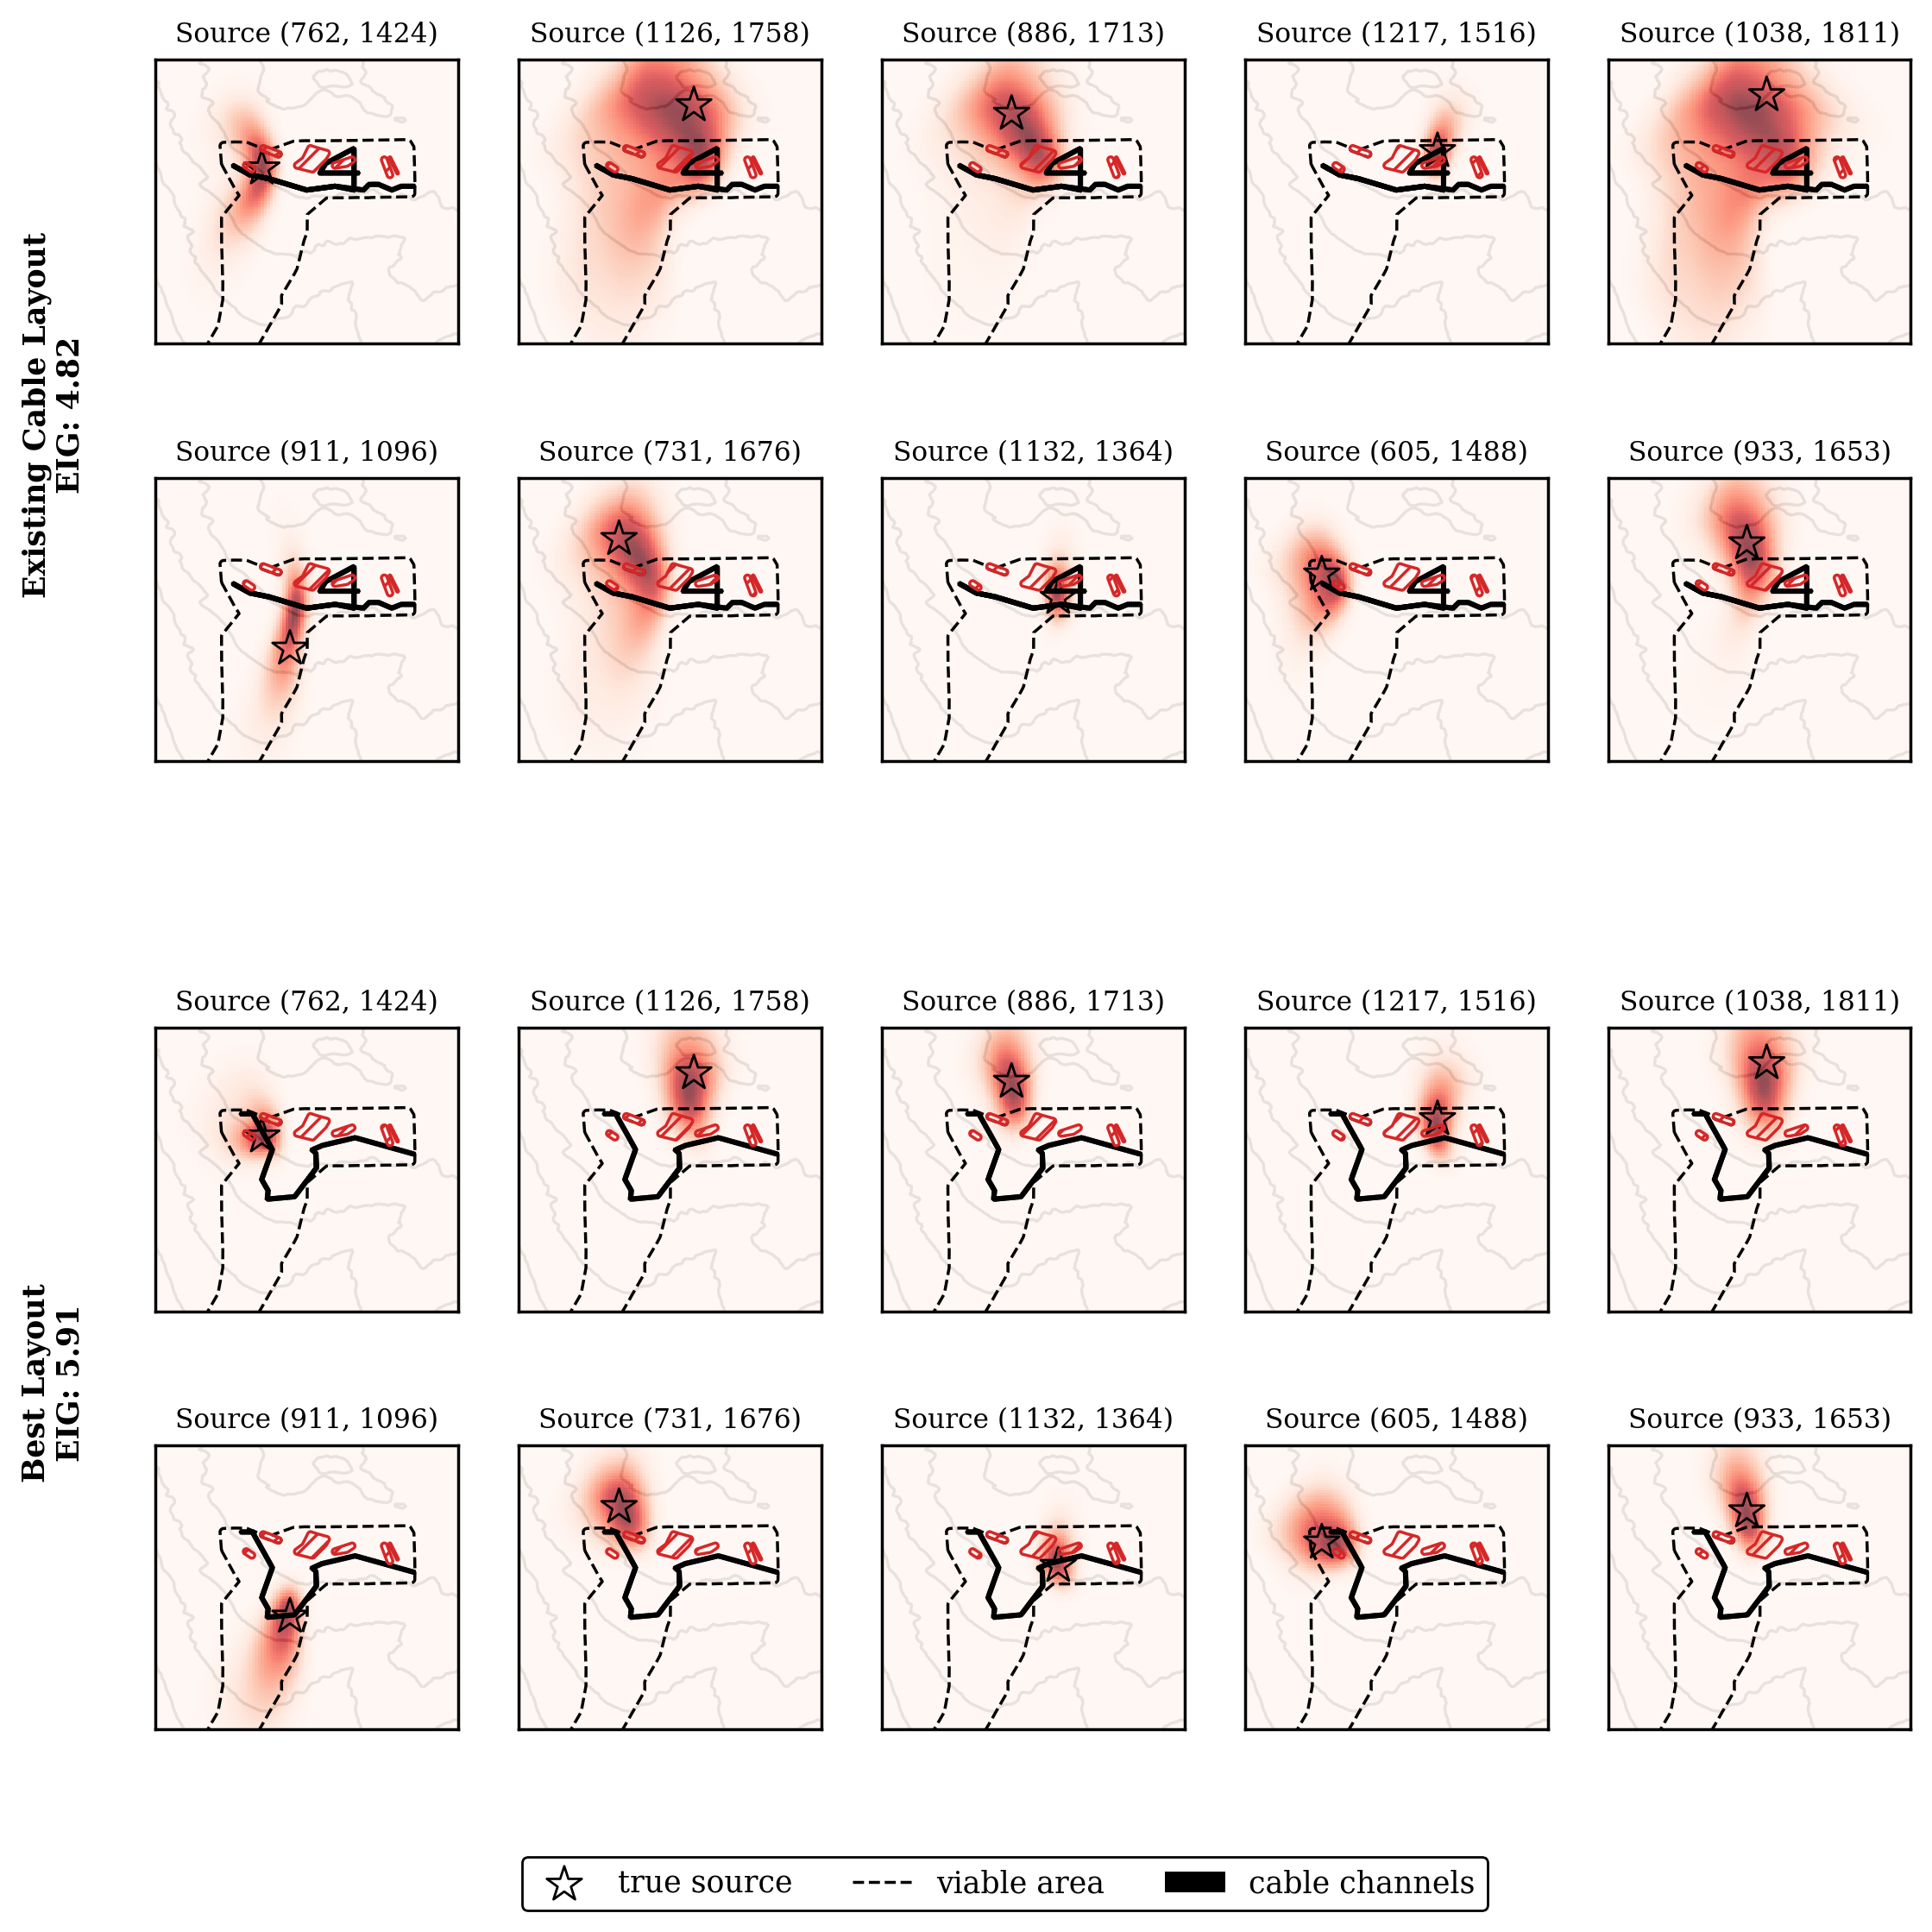

In [21]:
from dased.helpers.srcloc import calculate_posterior
import matplotlib.pyplot as plt
import shapely
from tqdm.auto import tqdm

eig_existing = eig_p(existing_cable)

# true_sources = prior_samples[:20, :][[1, 2, 4, 5, 6, 7, 9, 8, 0]].numpy()

true_sources = prior_samples[:20, :][[1, 2, 5, 7, 9, 10, 13, 15, 16, 18, ]].numpy()

# true_sources = prior_samples[:2, :].numpy()

def plot_posterior(
    ax,
    source,
    design,
    data_likelihood,
    topo_data,
    design_space,
    x_range,
    y_range,
    grid_size=100,
    seed=1,
    downsample=1,
):
    x_posterior, y_posterior, _, log_posterior, post_info = calculate_posterior(
        true_source=torch.tensor(source, dtype=torch.float64),
        design=design.get_gdf(),
        data_likelihood=data_likelihood,
        x_range=x_range,
        y_range=y_range,
        z_range=[source[2] - 100, source[2] + 100],
        grid_size=grid_size,
        prior_dist=prior_dist,
        seed=seed,
        clean_data=True,
        downsample=downsample,
    )
    posterior = log_posterior.exp().mean(dim=-1).numpy()

    # Plot topography
    contour = ax.contour(
        topo_data.x,
        topo_data.y,
        topo_data.values.T,
        colors="dimgray",
        alpha=0.5,
        levels=[1600, 1800, 2000, 2200, 2400, 2600],
        linewidths=1.0,
    )
    # Plot the posterior distribution
    ax.pcolormesh(
        x_posterior,
        y_posterior,
        posterior.T,
        shading="auto",
        cmap="Reds",
        alpha=0.7,
        zorder=2,
        rasterized=True,
    )
    # Plot the true source location
    ax.scatter(
        source[0],
        source[1],
        marker="*",
        s=150,
        edgecolor="black",
        # facecolor="yellow",
        facecolor="none",
        zorder=5,
        label="true source",
    )
    # Plot the design space boundary
    ax.plot(
        *shapely.geometry.polygon.Polygon(design_space_full).exterior.xy,
        "k--",
        linewidth=1,
        label="viable area",
    )
    # Plot the cable layout
    design.plot(
        ax=ax,
        plot_style="channels",
        zorder=4,
        color="k",
        width=0.02,
        alpha=1.0,
        label="cable channels",
    )
    # Set plot limits and aspect
    ax.set_xlim(*x_range)
    ax.set_ylim(*y_range)
    ax.set_aspect("equal")

# Use the same x/y range for all plots
x_range = (100, 2200)
y_range = (0, 2100)
data_likelihood = data_likelihood_P

layouts = [existing_cable] + top_layouts

n_sources = len(true_sources)
n_layouts = len(layouts)

# Option to plot all layouts or only existing vs best
plot_all = False  # Set to True to plot all layouts

if plot_all:
    selected_layouts = layouts
else:
    selected_layouts = [layouts[0], layouts[-1]]  # Existing vs best layout

n_selected_layouts = len(selected_layouts)

# Use 2 rows per layout
rows_per_layout = 2
sources_per_row = n_sources // rows_per_layout

# Create mosaic layout with dummy rows for spacing
mosaic_layout = []
for layout_idx in range(n_selected_layouts):
    # Add two rows for this layout
    for row_in_layout in range(rows_per_layout):
        row_key = f"layout_{layout_idx}_row_{row_in_layout}"
        mosaic_layout.append([f"{row_key}_{col}" for col in range(sources_per_row)])
    
    # Add dummy row for spacing (except after last layout)
    if layout_idx < n_selected_layouts - 1:
        mosaic_layout.append([f"dummy_{layout_idx}"] * sources_per_row)

# Create figure with subplot mosaic
fig, axes = plt.subplot_mosaic(
    mosaic_layout,
    figsize=(
        (x_range[1] - x_range[0]) / 1000 * sources_per_row, 
        (y_range[1] - y_range[0]) / 1000 * len(mosaic_layout)
    ),
    dpi=250,
    gridspec_kw={'height_ratios': [1 if 'dummy' not in row[0] else 0.2 for row in mosaic_layout]}
)
fig.set_facecolor("w")

# Hide dummy axes
for key in axes.keys():
    if 'dummy' in key:
        axes[key].set_visible(False)
        tasks_per_layout = min(rows_per_layout * sources_per_row, n_sources)
        total_tasks = n_selected_layouts * tasks_per_layout
        pbar = tqdm(total=total_tasks, desc="Posterior plots")

        for layout_idx, layout in enumerate(selected_layouts):
            for row_in_layout in range(rows_per_layout):
                for col in range(sources_per_row):
                    source_idx = row_in_layout * sources_per_row + col
                    if source_idx >= n_sources:
                        continue
                        
                    source = true_sources[source_idx]
                    ax_key = f"layout_{layout_idx}_row_{row_in_layout}_{col}"
                    ax = axes[ax_key]
                    
                    plot_posterior(
                        ax=ax,
                        source=source,
                        design=layout,
                        data_likelihood=data_likelihood,
                        topo_data=topo_data,
                        design_space=design_space_full,
                        x_range=(200, 1800),
                        y_range=(500, 2000),
                        grid_size=(100, 100, 10),
                        downsample=10,
                        seed=source_idx + 1,
                    )

                    for i, obstacle in enumerate(obstacles.geoms):
                        plot_polygon(
                            obstacle,
                            ax=ax,
                            facecolor="none",
                            edgecolor="tab:red",
                            linestyle="-",
                            linewidth=1.0,
                            add_points=False,
                            zorder=10,
                            hatch="////",
                            hatch_linewidth=1.0,
                        )

                    ax.set_title(f"Source ({int(source[0])}, {int(source[1])})", fontsize=9)
                    
                    # Remove labels and ticks
                    ax.set_ylabel("")
                    ax.set_xlabel("")
                    ax.set_xlim(200, 1800)
                    ax.set_ylim(500, 2000)
                    ax.set_xticks([])
                    ax.set_yticks([])

                    pbar.update(1)

        pbar.close()

# Add text labels for each layout
for layout_idx, layout in enumerate(selected_layouts):
    if layout_idx == 0:
        text = f"Existing Cable Layout\nEIG: {eig_existing:.2f}"
    else:
        text = f"Best Layout\nEIG: {top_fitness[-1]:.2f}"
    
    # Position text on the left side of the first subplot in each layout
    first_ax_key = f"layout_{layout_idx}_row_0_0"
    ax_pos = axes[first_ax_key].get_position()
    
    fig.text(
        0.08,  # x position (left edge)
        ax_pos.y0 - ax_pos.height / 4,  # y position (middle of first row)
        text,
        rotation=90,
        verticalalignment='center',
        horizontalalignment='center',
        fontsize=10,
        weight='bold'
    )

# Add legend at the bottom
first_ax_key = "layout_0_row_0_0"
handles, labels = axes[first_ax_key].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, 0.02),
    ncol=5,
    facecolor="white",
    edgecolor="black",
    fontsize=10,
)

fig.savefig("figures/eig_p_posterior_plots.png", bbox_inches="tight", dpi=250)
fig.savefig("figures/eig_p_posterior_plots.pdf", bbox_inches="tight", dpi=250)

plt.show()


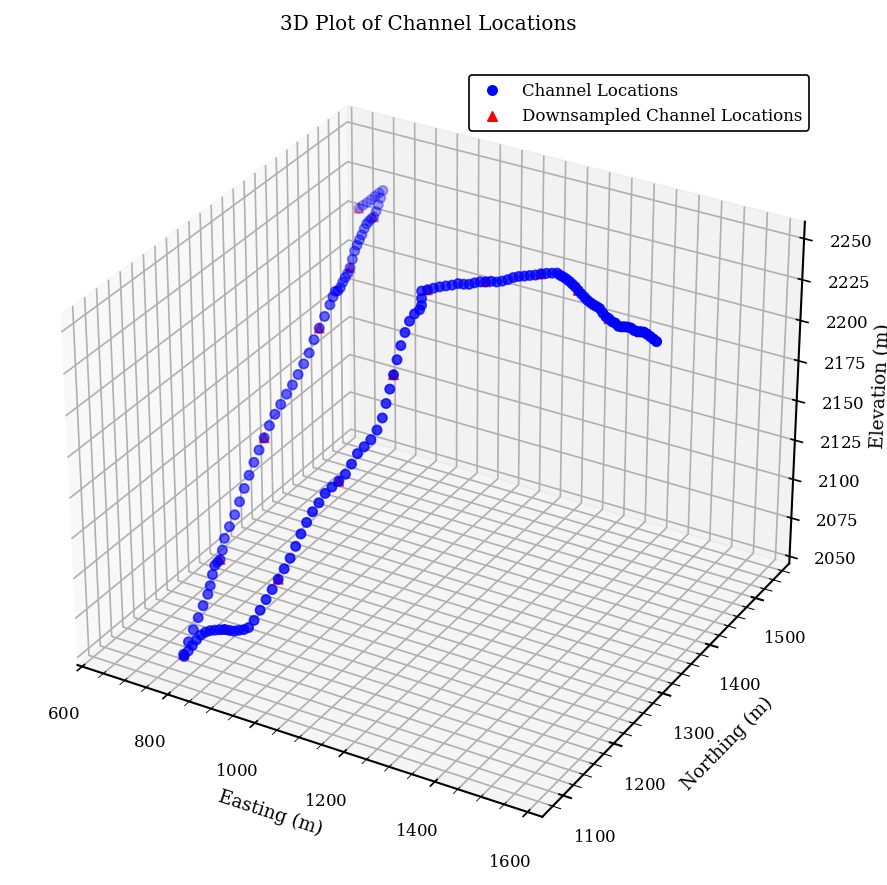

In [22]:
%matplotlib inline

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the channel locations
ax.scatter(
    best_layout_p.channel_locations[:, 0],
    best_layout_p.channel_locations[:, 1],
    best_layout_p.channel_locations[:, 2],
    c='blue', marker='o', label='Channel Locations')

ax.scatter(
    best_layout_p.channel_locations[5::10, 0],
    best_layout_p.channel_locations[5::10, 1],
    best_layout_p.channel_locations[5::10, 2],
    c='red', marker='^', label='Downsampled Channel Locations')

# Customize the plot
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_zlabel('Elevation (m)')
ax.set_title('3D Plot of Channel Locations')
ax.legend()

plt.tight_layout()
plt.show()

In [23]:
import time

# Benchmark single criterion evaluation
n_trials = 10
times = []

print("Benchmarking criterion evaluation...")
for i in range(n_trials):
    start = time.time()
    fitness = eig_p(best_layout_p)
    end = time.time()
    times.append(end - start)
    print(f"Trial {i+1}/{n_trials}: {end - start:.4f} seconds")

avg_time = np.mean(times)
std_time = np.std(times)

print(f"\nAverage evaluation time: {avg_time:.4f} ± {std_time:.4f} seconds")
print(f"Minimum: {np.min(times):.4f} seconds")
print(f"Maximum: {np.max(times):.4f} seconds")

Benchmarking criterion evaluation...
Trial 1/10: 0.2781 seconds
Trial 2/10: 0.2937 seconds
Trial 3/10: 0.2511 seconds
Trial 4/10: 0.2498 seconds
Trial 5/10: 0.2449 seconds
Trial 6/10: 0.2494 seconds
Trial 7/10: 0.2451 seconds
Trial 8/10: 0.2441 seconds
Trial 9/10: 0.2389 seconds
Trial 10/10: 0.2567 seconds

Average evaluation time: 0.2552 ± 0.0164 seconds
Minimum: 0.2389 seconds
Maximum: 0.2937 seconds


In [24]:
# Calculate total CPU hours for optimization
n_islands = archipelago.n_islands
population_size = archipelago.population_size
n_generations = 1000  # From the optimize call

# Total evaluations
total_evaluations = n_islands * population_size * n_generations

# Total time in seconds
total_time_seconds = total_evaluations * avg_time

# Convert to hours
total_time_hours = total_time_seconds / 3600

# Convert to CPU hours (sequential processing)
cpu_hours = total_time_hours

print("\n" + "="*60)
print("COMPUTATIONAL COST ESTIMATION")
print("="*60)
print(f"\nOptimization Configuration:")
print(f"  - Number of islands: {n_islands}")
print(f"  - Population size per island: {population_size}")
print(f"  - Number of generations: {n_generations}")
print(f"  - Average evaluation time: {avg_time:.4f} seconds")

print(f"\nTotal Evaluations:")
print(f"  - Per generation: {n_islands * population_size:,}")
print(f"  - Total: {total_evaluations:,}")

print(f"\nComputational Time:")
print(f"  - Total sequential time: {total_time_seconds:,.1f} seconds ({total_time_hours:.2f} hours)")
print(f"  - If parallelized across {n_islands} islands: {total_time_hours/n_islands:.2f} hours")
print(f"  - Total CPU hours: {cpu_hours:.2f}")

print(f"\nTime Breakdown:")
print(f"  - Per generation (sequential): {n_islands * population_size * avg_time:.2f} seconds ({n_islands * population_size * avg_time/60:.2f} minutes)")
print(f"  - Per generation (parallelized): {population_size * avg_time:.2f} seconds ({population_size * avg_time/60:.2f} minutes)")

print("="*60)


COMPUTATIONAL COST ESTIMATION

Optimization Configuration:
  - Number of islands: 16
  - Population size per island: 128
  - Number of generations: 1000
  - Average evaluation time: 0.2552 seconds

Total Evaluations:
  - Per generation: 2,048
  - Total: 2,048,000

Computational Time:
  - Total sequential time: 522,630.5 seconds (145.18 hours)
  - If parallelized across 16 islands: 9.07 hours
  - Total CPU hours: 145.18

Time Breakdown:
  - Per generation (sequential): 522.63 seconds (8.71 minutes)
  - Per generation (parallelized): 32.66 seconds (0.54 minutes)


In [50]:
import time

# Test runtime for different decimation factors
test_factors = [1, 2, 5, 10, 20]
n_trials = 10

print("="*60)
print("DECIMATION RUNTIME ANALYSIS")
print("="*60)

runtime_results = {}

for factor in test_factors:
    times = []
    
    # Create EIG criterion with this decimation factor
    eig_test = EIGCriterion(
        prior_samples,
        data_likelihood=data_likelihood_P,
        eig_method="NMC",
        N=2000,
        downsample=factor,
        memory_efficient=True,
    )
    
    # Benchmark
    for trial in range(n_trials):
        start = time.time()
        _ = eig_test(best_layout_p)
        elapsed = time.time() - start
        times.append(elapsed)
    
    avg_time = np.mean(times)
    runtime_results[factor] = avg_time
    n_channels = len(best_layout_p.channel_locations[::factor])
    
    print(f"Factor {factor:2d}x ({n_channels:3d} channels): {avg_time:.3f}s ± {np.std(times):.3f}s")

print("="*60)
print(f"\nSpeedup vs baseline (1x): {runtime_results[1]/runtime_results[20]:.1f}x at 20x decimation")
print(f"Baseline: {runtime_results[1]:.2f}s → Decimated (20x): {runtime_results[20]:.2f}s")

DECIMATION RUNTIME ANALYSIS
Factor  1x (166 channels): 6.933s ± 0.248s
Factor  2x ( 83 channels): 3.897s ± 0.068s
Factor  5x ( 34 channels): 1.766s ± 0.030s
Factor 10x ( 17 channels): 1.188s ± 0.044s
Factor 20x (  9 channels): 1.022s ± 0.018s

Speedup vs baseline (1x): 6.8x at 20x decimation
Baseline: 6.93s → Decimated (20x): 1.02s


SAMPLE SIZE (N) RUNTIME ANALYSIS
Fixed decimation factor: 10x

N =  100: 0.065s ± 0.003s
N =  500: 0.200s ± 0.009s
N = 1000: 0.431s ± 0.020s
N = 2000: 1.227s ± 0.013s
N = 5000: 6.188s ± 0.140s

Scaling factor (N=2000 / N=100): 18.8x
Runtime: N=100 (0.07s) → N=2000 (1.23s)

SCALING LAW FIT
Runtime = 0.000003 × N^1.725

Theoretical scaling for NMC: O(N^2)
Measured scaling exponent: 1.725


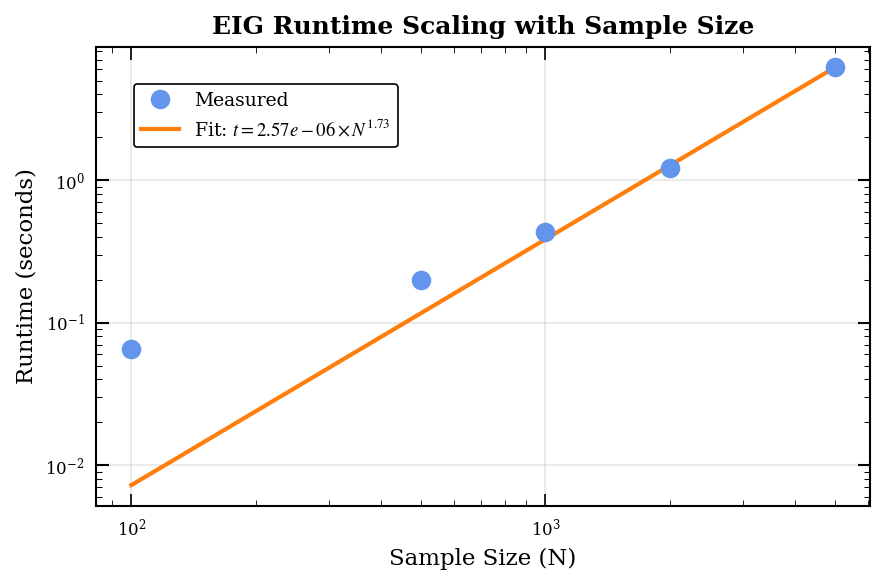

In [52]:
# Test runtime effect of N (sample size)
test_N_values = [100, 500, 1000, 2000, 5000]
n_trials = 3
test_decimation = 10  # Fixed decimation factor

print("="*60)
print("SAMPLE SIZE (N) RUNTIME ANALYSIS")
print("="*60)
print(f"Fixed decimation factor: {test_decimation}x")
print()

N_runtime_results = {}

for N_test in test_N_values:
    times = []
    
    # Create EIG criterion with this N
    eig_test = EIGCriterion(
        prior_samples[:N_test],
        data_likelihood=data_likelihood_P,
        eig_method="NMC",
        N=N_test,
        downsample=test_decimation,
        memory_efficient=True,
    )
    
    # Benchmark
    for trial in range(n_trials):
        start = time.time()
        _ = eig_test(best_layout_p)
        elapsed = time.time() - start
        times.append(elapsed)
    
    avg_time = np.mean(times)
    N_runtime_results[N_test] = avg_time
    
    print(f"N = {N_test:4d}: {avg_time:.3f}s ± {np.std(times):.3f}s")

print("="*60)
print(f"\nScaling factor (N=2000 / N=100): {N_runtime_results[2000]/N_runtime_results[100]:.1f}x")
print(f"Runtime: N=100 ({N_runtime_results[100]:.2f}s) → N=2000 ({N_runtime_results[2000]:.2f}s)")

# Fit scaling law: runtime = a * N^b
from scipy.optimize import curve_fit

N_array = np.array(list(N_runtime_results.keys()))
time_array = np.array(list(N_runtime_results.values()))

def power_law(N, a, b):
    return a * N**b

# Fit the power law
popt, pcov = curve_fit(power_law, N_array, time_array)
a_fit, b_fit = popt

print(f"\n" + "="*60)
print("SCALING LAW FIT")
print("="*60)
print(f"Runtime = {a_fit:.6f} × N^{b_fit:.3f}")
print(f"\nTheoretical scaling for NMC: O(N^2)")
print(f"Measured scaling exponent: {b_fit:.3f}")
print("="*60)

# Plot the results
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

# Plot measured data points
ax.plot(N_array, time_array, 'o', markersize=8, color='cornflowerblue', 
        label='Measured', zorder=3)

# Plot fitted curve
N_fit = np.linspace(N_array.min(), N_array.max(), 100)
time_fit = power_law(N_fit, a_fit, b_fit)
ax.plot(N_fit, time_fit, '-', linewidth=2, color='tab:orange', 
        label=f'Fit: $t = {a_fit:.2e} \\times N^{{{b_fit:.2f}}}$', zorder=2)

ax.set_xlabel('Sample Size (N)', fontsize=11)
ax.set_ylabel('Runtime (seconds)', fontsize=11)
ax.set_title('EIG Runtime Scaling with Sample Size', fontsize=12, weight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left', fontsize=9)

# Use log-log scale to show power law
ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.show()


# Channel Spacing Decimation Analysis

Analyze how decimating the channel spacing affects the EIG for the optimal layout.

In [25]:
import os

# Test parameters
decimation_factors = [1, 2, 3, 4, 5, 6, 8, 10, 15, 20]
correlation_lengths = [0, 100, 200, 500, 1000]
N_values = [1000, 2000, 5000]

# Get one representative layout for testing
test_layout = best_layout_p

# Define save directory
save_dir = "data/correlation_test"
os.makedirs(save_dir, exist_ok=True)

# Function to get filename for a specific configuration
def get_filename(cor_len, N):
    return f"{save_dir}/eig_corr{cor_len}_N{N}.npy"

# Function to check if all results exist
def check_all_results_exist():
    for cor_len in correlation_lengths:
        for N in N_values:
            if not os.path.exists(get_filename(cor_len, N)):
                return False
    return True

# Try to load existing results
all_exist = check_all_results_exist()

if all_exist:
    print("="*80)
    print("LOADING EXISTING RESULTS")
    print("="*80)
    results = {}
    for cor_len in correlation_lengths:
        results[cor_len] = {}
        for N in N_values:
            filename = get_filename(cor_len, N)
            results[cor_len][N] = np.load(filename).tolist()
    print(f"Loaded results for {len(correlation_lengths)} correlation lengths × {len(N_values)} N values × {len(decimation_factors)} decimation factors")
    print("="*80)
else:
    # Store results in nested dictionary: results[cor_len][N][decimation_idx]
    results = {cor_len: {n: [] for n in N_values} for cor_len in correlation_lengths}
    
    print("="*80)
    print("COMPREHENSIVE DECIMATION ANALYSIS")
    print("="*80)
    print(f"Testing {len(correlation_lengths)} correlation lengths × {len(N_values)} N values × {len(decimation_factors)} decimation factors")
    print(f"Total: {len(correlation_lengths) * len(N_values) * len(decimation_factors)} configurations")
    print("="*80)
    print()
    
    # Create progress bar for all combinations
    total_combinations = len(correlation_lengths) * len(N_values) * len(decimation_factors)
    pbar = tqdm(total=total_combinations, desc="Overall progress")
    
    for cor_len in correlation_lengths:
        print(f"\n{'='*60}")
        print(f"Correlation Length: {cor_len}m")
        print(f"{'='*60}")
        
        for N in N_values:
            # Check if this specific result already exists
            filename = get_filename(cor_len, N)
            if os.path.exists(filename):
                print(f"\n  N = {N} - LOADING FROM FILE")
                print(f"  {'-'*50}")
                results[cor_len][N] = np.load(filename).tolist()
                print(f"    Loaded: EIG[factor=1] = {results[cor_len][N][0]:.2f}, EIG[factor=20] = {results[cor_len][N][-1]:.2f}")
                # Update progress bar for all decimation factors
                pbar.update(len(decimation_factors))
                continue
            
            print(f"\n  N = {N} - COMPUTING")
            print(f"  {'-'*50}")
            
            # Create data likelihood for this correlation length
            if cor_len == 0:
                data_likelihood_test = DataLikelihood(
                    forward_function=dict(P=forward_function_P),
                    std_corr=std_corr,
                    std_uncorr=std_uncorr,
                    f_max=f_max,
                    # std_cutoff=2,
                )
            else:
                data_likelihood_test = DataLikelihood(
                    forward_function=dict(P=forward_function_P),
                    std_corr=std_corr,
                    std_uncorr=std_uncorr,
                    cor_length=cor_len,
                    f_max=f_max,
                    # std_cutoff=2,
                )
            
            for factor in decimation_factors:
                # Create EIG criterion with memory_efficient=True
                eig_test = EIGCriterion(
                    prior_samples[:N],
                    data_likelihood=data_likelihood_test,
                    eig_method="NMC",
                    N=N,
                    downsample=factor,
                    memory_efficient=True,
                )
                
                # Calculate EIG
                eig_val = eig_test(test_layout)
                results[cor_len][N].append(eig_val)
                
                pbar.update(1)
            
            # Save this specific result immediately after computing
            np.save(filename, np.array(results[cor_len][N]))
            print(f"    Computed & saved: EIG[factor=1] = {results[cor_len][N][0]:.2f}, EIG[factor=20] = {results[cor_len][N][-1]:.2f}")
    
    pbar.close()
    
    print("\n" + "="*80)
    print("ANALYSIS COMPLETE - All results saved")
    print("="*80)
    print(f"Results saved in: {save_dir}/")
    print(f"File format: eig_corr<correlation_length>_N<sample_size>.npy")

COMPREHENSIVE DECIMATION ANALYSIS
Testing 5 correlation lengths × 2 N values × 10 decimation factors
Total: 100 configurations



Overall progress:   0%|          | 0/100 [00:00<?, ?it/s]


Correlation Length: 0m

  N = 1000 - LOADING FROM FILE
  --------------------------------------------------
    Loaded: EIG[factor=1] = 6.79, EIG[factor=20] = 3.97

  N = 2000 - COMPUTING
  --------------------------------------------------
    Computed & saved: EIG[factor=1] = 7.39, EIG[factor=20] = 4.04

Correlation Length: 100m

  N = 1000 - LOADING FROM FILE
  --------------------------------------------------
    Loaded: EIG[factor=1] = 6.79, EIG[factor=20] = 3.97

  N = 2000 - COMPUTING
  --------------------------------------------------
    Computed & saved: EIG[factor=1] = 7.36, EIG[factor=20] = 4.04

Correlation Length: 200m

  N = 1000 - LOADING FROM FILE
  --------------------------------------------------
    Loaded: EIG[factor=1] = 6.79, EIG[factor=20] = 3.97

  N = 2000 - COMPUTING
  --------------------------------------------------
    Computed & saved: EIG[factor=1] = 7.32, EIG[factor=20] = 4.04

Correlation Length: 500m

  N = 1000 - LOADING FROM FILE
  ------------

In [26]:
# Calculate effective channel spacings
original_spacing = cable_properties["spacing"]
effective_spacings = [original_spacing * factor for factor in decimation_factors]
n_channels_list = [len(test_layout.channel_locations[::factor]) for factor in decimation_factors]

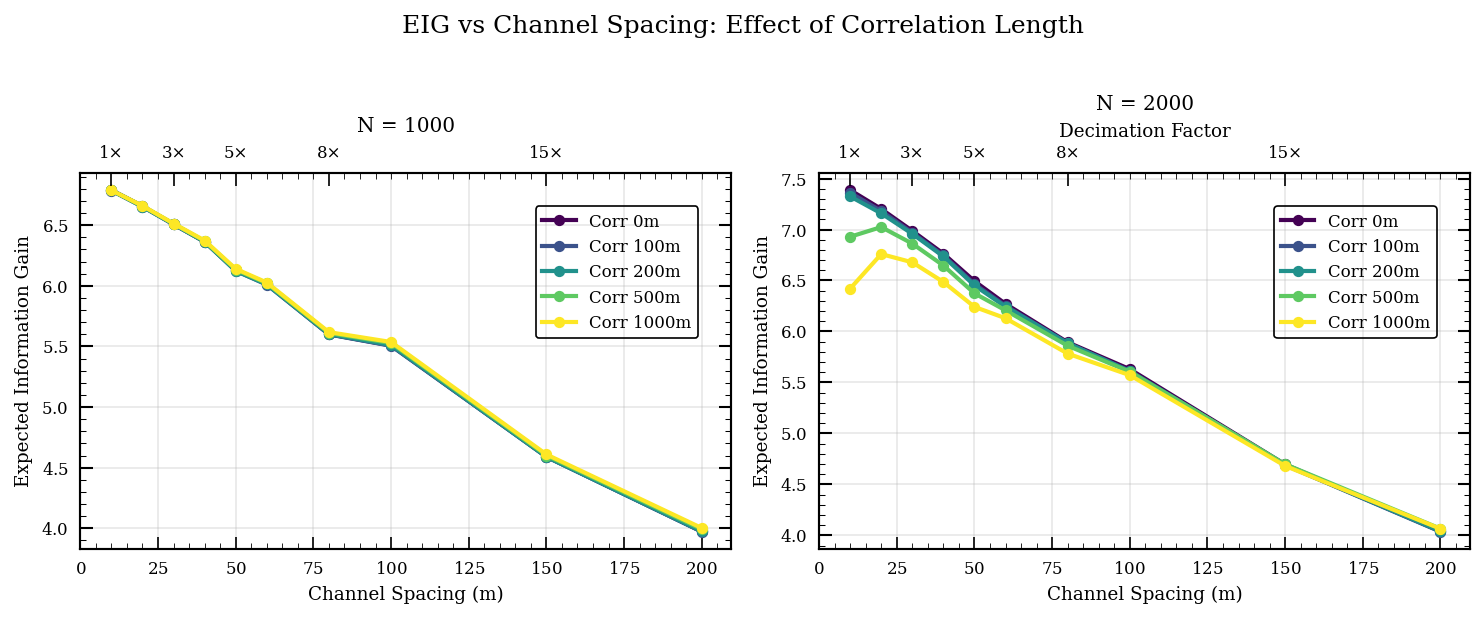

In [27]:
# Plot 1: Effect of correlation length for different N values
fig, axes = plt.subplots(1, len(N_values), figsize=(5*len(N_values), 4), dpi=150)
if len(N_values) == 1:
    axes = [axes]

cmap = plt.get_cmap('viridis')
colors = [cmap(i / (len(correlation_lengths) - 1)) for i in range(len(correlation_lengths))]

for idx, N in enumerate(N_values):
    ax = axes[idx]
    
    for i, cor_len in enumerate(correlation_lengths):
        ax.plot(effective_spacings, results[cor_len][N], 'o-', 
                color=colors[i], linewidth=2, markersize=4, 
                label=f'Corr {cor_len}m')
    
    ax.set_xlabel('Channel Spacing (m)')
    ax.set_ylabel('Expected Information Gain')
    ax.set_title(f'N = {N}')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=8)
    ax.set_xlim(left=0)
    
    # Add secondary x-axis showing decimation factor
    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())
    ax_top.set_xticks(effective_spacings[::2])  # Show every other tick
    ax_top.set_xticklabels([f'{f}×' for f in decimation_factors[::2]])
    if idx == len(N_values) // 2:
        ax_top.set_xlabel('Decimation Factor')

plt.suptitle('EIG vs Channel Spacing: Effect of Correlation Length', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

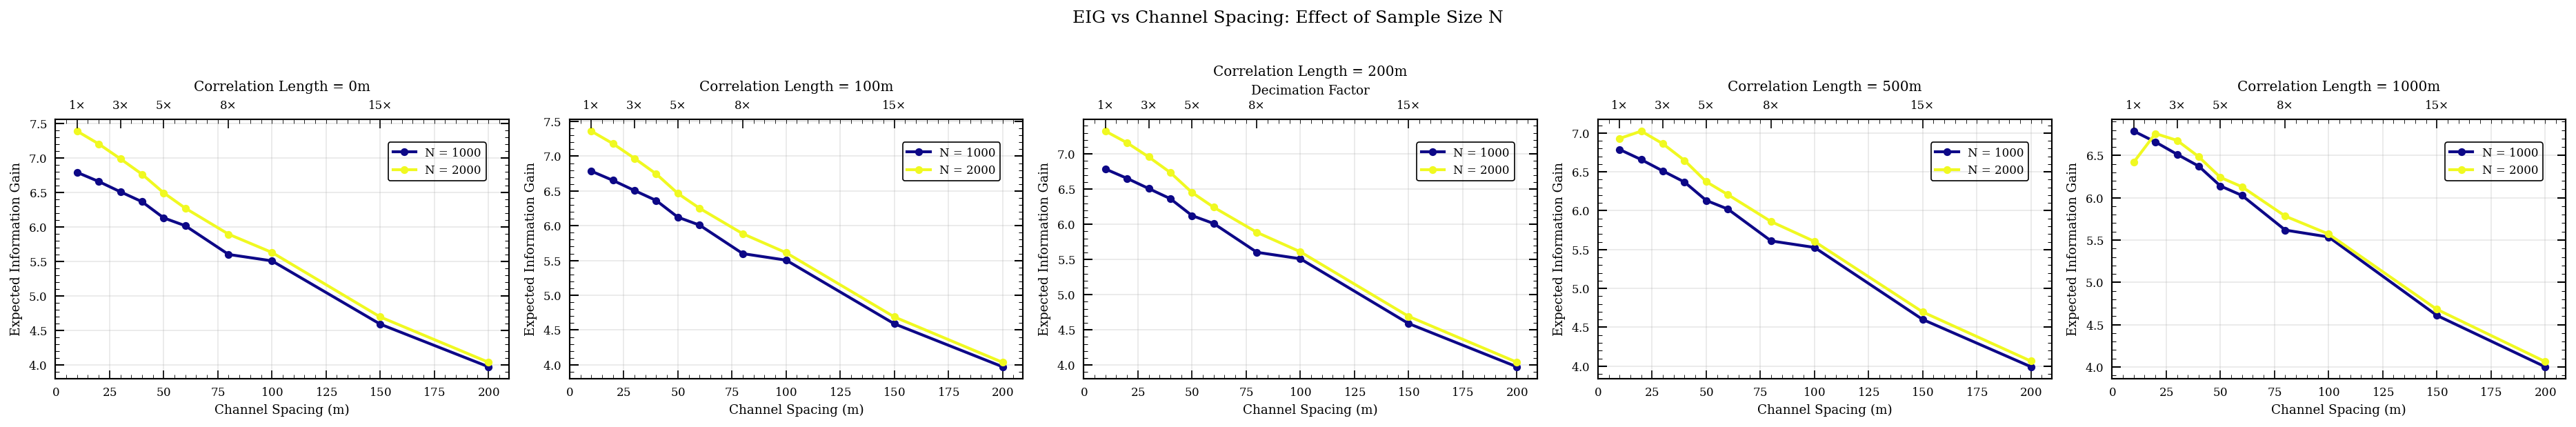

In [28]:
# Plot 2: Effect of N for different correlation lengths
fig, axes = plt.subplots(1, len(correlation_lengths), figsize=(5*len(correlation_lengths), 4), dpi=150)
if len(correlation_lengths) == 1:
    axes = [axes]

cmap = plt.get_cmap('plasma')
colors = [cmap(i / (len(N_values) - 1)) for i in range(len(N_values))]

for idx, cor_len in enumerate(correlation_lengths):
    ax = axes[idx]
    
    for i, N in enumerate(N_values):
        ax.plot(effective_spacings, results[cor_len][N], 'o-', 
                color=colors[i], linewidth=2, markersize=4, 
                label=f'N = {N}')
    
    ax.set_xlabel('Channel Spacing (m)')
    ax.set_ylabel('Expected Information Gain')
    ax.set_title(f'Correlation Length = {cor_len}m')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=8)
    ax.set_xlim(left=0)
    
    # Add secondary x-axis showing decimation factor
    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())
    ax_top.set_xticks(effective_spacings[::2])
    ax_top.set_xticklabels([f'{f}×' for f in decimation_factors[::2]])
    if idx == len(correlation_lengths) // 2:
        ax_top.set_xlabel('Decimation Factor')

plt.suptitle('EIG vs Channel Spacing: Effect of Sample Size N', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

# Optimization Consistency Analysis

Analyze if optimization results are consistent across different correlation lengths and N values by evaluating 10 random designs from the optimization history.

In [31]:
# Get 10 random designs from optimization history
n_designs = 10
random_layouts, random_fitness = archipelago.get_n_spread_single(n_designs, from_history=True)

print(f"Selected {len(random_layouts)} designs for consistency analysis")
print(f"Fitness range: {min(random_fitness):.2f} - {max(random_fitness):.2f}")
print(f"Mean fitness: {np.mean(random_fitness):.2f} ± {np.std(random_fitness):.2f}")

Selected 10 designs for consistency analysis
Fitness range: 5.15 - 5.91
Mean fitness: 5.53 ± 0.24


In [32]:
# Calculate EIG for each design across all correlation lengths and N values
# Store results in: consistency_results[design_idx][cor_len][N]
consistency_results = {}

save_dir_consistency = "data/correlation_test"
os.makedirs(save_dir_consistency, exist_ok=True)

print("="*80)
print("CONSISTENCY ANALYSIS: Evaluating random designs")
print("="*80)
print(f"Designs: {n_designs}")
print(f"Correlation lengths: {correlation_lengths}")
print(f"N values: {N_values}")
print(f"Total evaluations: {n_designs * len(correlation_lengths) * len(N_values)}")
print("="*80)

# Create progress bar
total_evals = n_designs * len(correlation_lengths) * len(N_values)
pbar = tqdm(total=total_evals, desc="Evaluating designs")

for design_idx, layout in enumerate(random_layouts):
    consistency_results[design_idx] = {}
    
    for cor_len in correlation_lengths:
        consistency_results[design_idx][cor_len] = {}
        
        # Create data likelihood for this correlation length
        if cor_len == 0:
            data_likelihood_test = DataLikelihood(
                forward_function=dict(P=forward_function_P),
                std_corr=std_corr,
                std_uncorr=std_uncorr,
                f_max=f_max,
            )
        else:
            data_likelihood_test = DataLikelihood(
                forward_function=dict(P=forward_function_P),
                std_corr=std_corr,
                std_uncorr=std_uncorr,
                cor_length=cor_len,
                f_max=f_max,
            )
        
        for N in N_values:
            # Create EIG criterion
            eig_test = EIGCriterion(
                prior_samples[:N],
                data_likelihood=data_likelihood_test,
                eig_method="NMC",
                N=N,
                downsample=10,
                memory_efficient=True,
            )
            
            # Calculate EIG
            eig_val = eig_test(layout)
            consistency_results[design_idx][cor_len][N] = eig_val
            
            pbar.update(1)

pbar.close()

print("\n" + "="*80)
print("CONSISTENCY ANALYSIS COMPLETE")
print("="*80)

CONSISTENCY ANALYSIS: Evaluating random designs
Designs: 10
Correlation lengths: [0, 100, 200, 500, 1000]
N values: [1000, 2000]
Total evaluations: 100


Evaluating designs:   0%|          | 0/100 [00:00<?, ?it/s]


CONSISTENCY ANALYSIS COMPLETE


In [37]:
# Calculate EIG for each design across decimation factors and correlation lengths
# Store results in: consistency_decimation_results[design_idx][cor_len][N][decimation_idx]
consistency_decimation_results = {}

# Use same decimation factors and correlation lengths as before
test_cor_lengths = [0, 100]  # Compare no correlation vs 100m correlation
test_N_values = [1000, 2000]  # Test different N values

print("="*80)
print("DECIMATION ROBUSTNESS ANALYSIS: Evaluating random designs")
print("="*80)
print(f"Designs: {n_designs}")
print(f"Decimation factors: {decimation_factors}")
print(f"Correlation lengths: {test_cor_lengths}")
print(f"N values: {test_N_values}")
print(f"Total evaluations: {n_designs * len(decimation_factors) * len(test_cor_lengths) * len(test_N_values)}")
print("="*80)

# Create progress bar
total_evals = n_designs * len(decimation_factors) * len(test_cor_lengths) * len(test_N_values)
pbar = tqdm(total=total_evals, desc="Evaluating designs across decimation factors")

for design_idx, layout in enumerate(random_layouts):
    consistency_decimation_results[design_idx] = {}
    
    for cor_len in test_cor_lengths:
        consistency_decimation_results[design_idx][cor_len] = {}
        
        # Create data likelihood for this correlation length
        if cor_len == 0:
            data_likelihood_test = DataLikelihood(
                forward_function=dict(P=forward_function_P),
                std_corr=std_corr,
                std_uncorr=std_uncorr,
                f_max=f_max,
            )
        else:
            data_likelihood_test = DataLikelihood(
                forward_function=dict(P=forward_function_P),
                std_corr=std_corr,
                std_uncorr=std_uncorr,
                cor_length=cor_len,
                f_max=f_max,
            )
        
        for N in test_N_values:
            consistency_decimation_results[design_idx][cor_len][N] = []
            
            for factor in decimation_factors:
                # Create EIG criterion
                eig_test = EIGCriterion(
                    prior_samples[:N],
                    data_likelihood=data_likelihood_test,
                    eig_method="NMC",
                    N=N,
                    downsample=factor,
                    memory_efficient=True,
                )
                
                # Calculate EIG
                eig_val = eig_test(layout)
                consistency_decimation_results[design_idx][cor_len][N].append(eig_val)
                
                pbar.update(1)

pbar.close()

print("\n" + "="*80)
print("DECIMATION ROBUSTNESS ANALYSIS COMPLETE")
print("="*80)

DECIMATION ROBUSTNESS ANALYSIS: Evaluating random designs
Designs: 10
Decimation factors: [1, 2, 3, 4, 5, 6, 8, 10, 15, 20]
Correlation lengths: [0, 100]
N values: [1000, 2000]
Total evaluations: 400


Evaluating designs across decimation factors:   0%|          | 0/400 [00:00<?, ?it/s]


DECIMATION ROBUSTNESS ANALYSIS COMPLETE


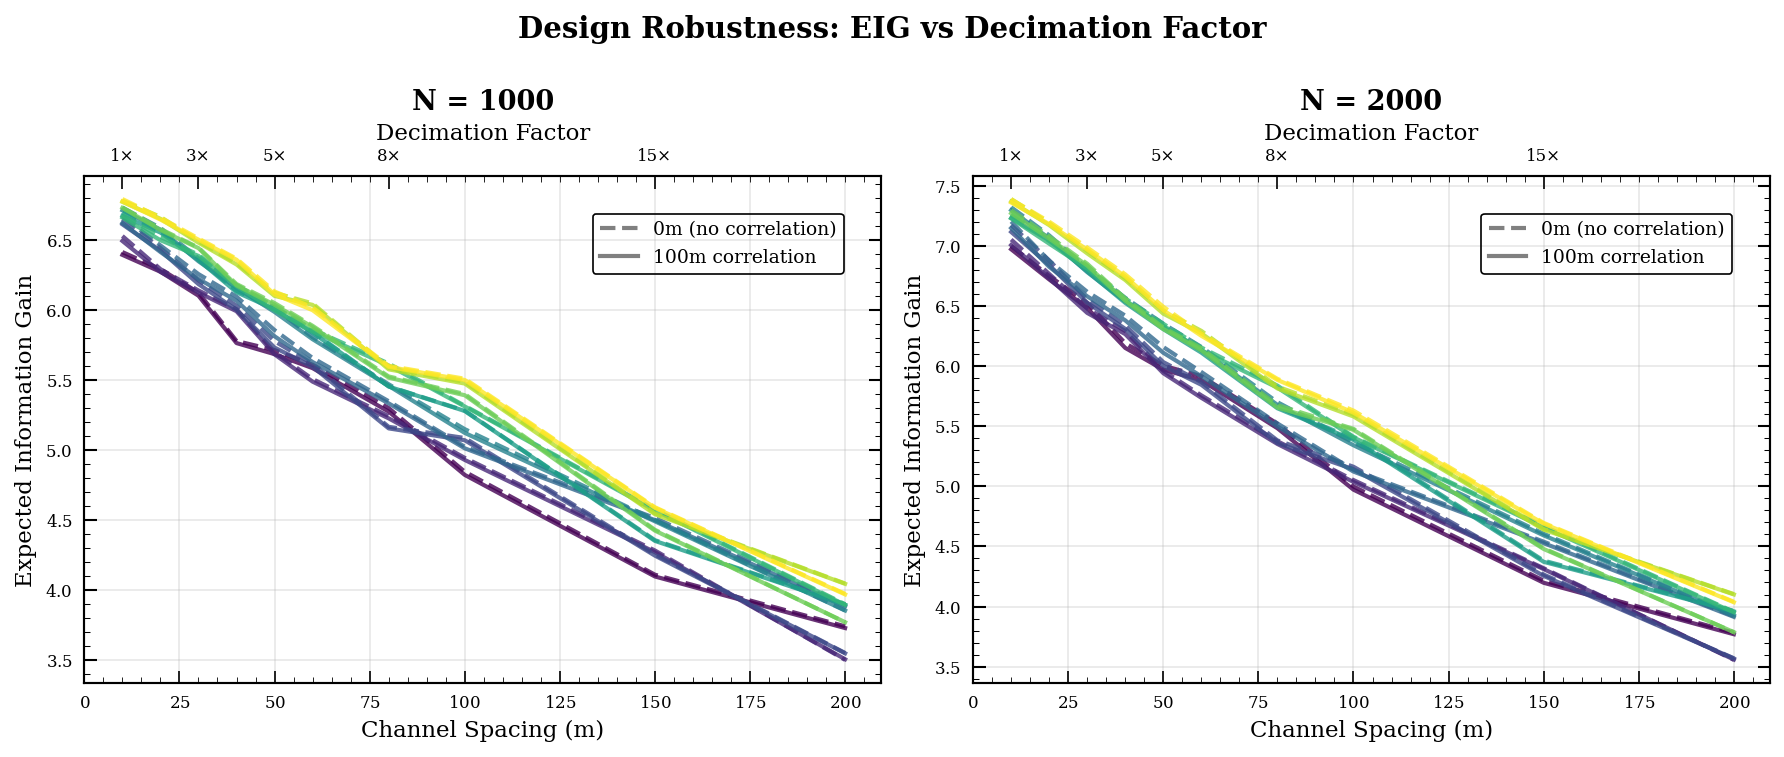

In [43]:
# Plot EIG vs Decimation Factor for each N value
# Different designs colored with viridis, 0m correlation as dashed line

fig, axes = plt.subplots(1, len(test_N_values), figsize=(6*len(test_N_values), 5), dpi=150)
if len(test_N_values) == 1:
    axes = [axes]

# Use viridis colormap for designs
cmap = plt.get_cmap('viridis')
design_colors = [cmap(i / (n_designs - 1)) for i in range(n_designs)]

for idx, N in enumerate(test_N_values):
    ax = axes[idx]
    
    # Plot each design
    for design_idx in range(n_designs):
        # Plot 0m correlation (no correlation) with dashed line
        eig_0m = consistency_decimation_results[design_idx][0][N]
        ax.plot(effective_spacings, eig_0m, '--', 
                color=design_colors[design_idx], linewidth=2, 
                alpha=0.8, label=f'Design {design_idx+1} (0m)' if idx == 0 else None)
        
        # Plot 100m correlation with solid line
        eig_100m = consistency_decimation_results[design_idx][100][N]
        ax.plot(effective_spacings, eig_100m, '-', 
                color=design_colors[design_idx], linewidth=2, 
                alpha=0.8, label=f'Design {design_idx+1} (100m)' if idx == 0 else None)
    
    ax.set_xlabel('Channel Spacing (m)', fontsize=11)
    ax.set_ylabel('Expected Information Gain', fontsize=11)
    ax.set_title(f'N = {N}', fontsize=13, weight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(left=0)
    
    # Add secondary x-axis showing decimation factor
    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())
    ax_top.set_xticks(effective_spacings[::2])
    ax_top.set_xticklabels([f'{f}×' for f in decimation_factors[::2]])
    ax_top.set_xlabel('Decimation Factor', fontsize=11)
    
    # Add legend for correlation lengths
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='gray', linewidth=2, linestyle='--', label='0m (no correlation)'),
        Line2D([0], [0], color='gray', linewidth=2, linestyle='-', label='100m correlation')
    ]
    ax.legend(handles=legend_elements, loc='best', fontsize=9)

plt.suptitle('Design Robustness: EIG vs Decimation Factor', y=1.00, fontsize=14, weight='bold')
plt.tight_layout()

plt.show()

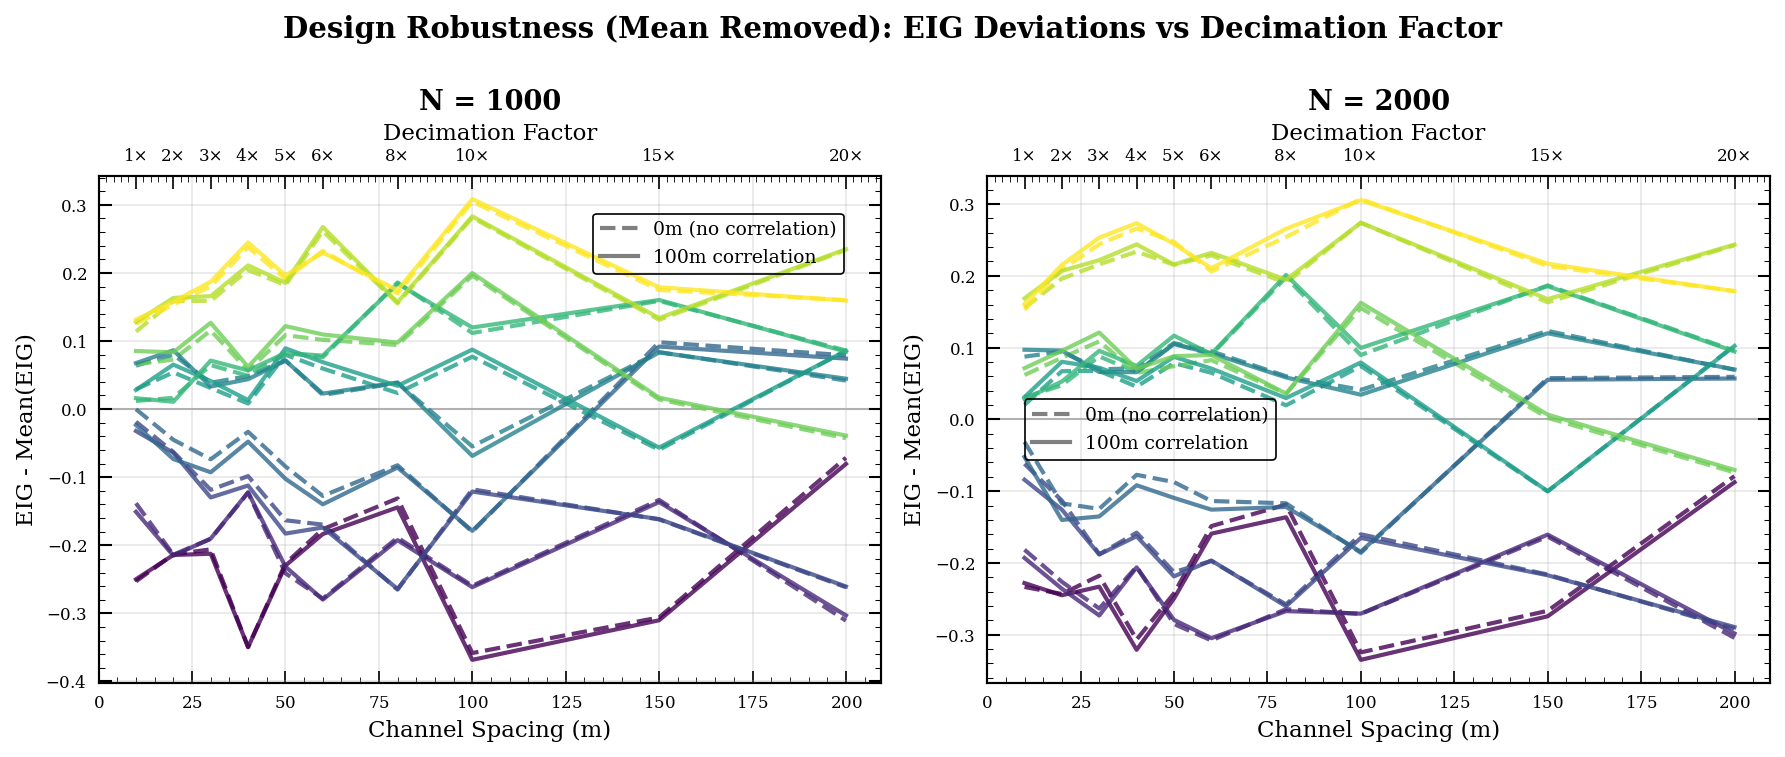

In [45]:
# Plot normalized EIG (mean removed) vs Decimation Factor for each N value
# This shows relative differences between designs more clearly

fig, axes = plt.subplots(1, len(test_N_values), figsize=(6*len(test_N_values), 5), dpi=150)
if len(test_N_values) == 1:
    axes = [axes]

# Use viridis colormap for designs
cmap = plt.get_cmap('viridis')
design_colors = [cmap(i / (n_designs - 1)) for i in range(n_designs)]

for idx, N in enumerate(test_N_values):
    ax = axes[idx]
    
    # Calculate mean EIG at each decimation factor for normalization
    for cor_len in test_cor_lengths:
        # Collect all EIG values at each decimation factor
        all_eig_at_decimation = np.zeros((n_designs, len(decimation_factors)))
        for design_idx in range(n_designs):
            all_eig_at_decimation[design_idx, :] = consistency_decimation_results[design_idx][cor_len][N]
        
        # Calculate mean at each decimation factor
        mean_eig_at_decimation = np.mean(all_eig_at_decimation, axis=0)
        
        # Plot each design with mean removed
        for design_idx in range(n_designs):
            eig_normalized = all_eig_at_decimation[design_idx, :] - mean_eig_at_decimation
            
            if cor_len == 0:
                ax.plot(effective_spacings, eig_normalized, '--', 
                        color=design_colors[design_idx], linewidth=2, 
                        alpha=0.8)
            else:
                ax.plot(effective_spacings, eig_normalized, '-', 
                        color=design_colors[design_idx], linewidth=2, 
                        alpha=0.8)
    
    # Add zero reference line
    ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.3, zorder=-1)
    
    ax.set_xlabel('Channel Spacing (m)', fontsize=11)
    ax.set_ylabel('EIG - Mean(EIG)', fontsize=11)
    ax.set_title(f'N = {N}', fontsize=13, weight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(left=0)
    
    # Add secondary x-axis showing decimation factor
    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())
    ax_top.set_xticks(effective_spacings[::1])
    ax_top.set_xticklabels([f'{f}×' for f in decimation_factors[::1]])
    ax_top.set_xlabel('Decimation Factor', fontsize=11)
    
    # Add legend for correlation lengths
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='gray', linewidth=2, linestyle='--', label='0m (no correlation)'),
        Line2D([0], [0], color='gray', linewidth=2, linestyle='-', label='100m correlation')
    ]
    ax.legend(handles=legend_elements, loc='best', fontsize=9)

plt.suptitle('Design Robustness (Mean Removed): EIG Deviations vs Decimation Factor', y=1.00, fontsize=14, weight='bold')
plt.tight_layout()

plt.show()

In [ ]:
# Analyze the robustness: Calculate coefficient of variation (CV) for each design
# CV = std / mean, lower CV means more robust to decimation

print("="*80)
print("ROBUSTNESS METRICS: Coefficient of Variation across Decimation Factors")
print("="*80)

for N in test_N_values:
    print(f"\nN = {N}")
    print("-"*60)
    
    for cor_len in test_cor_lengths:
        print(f"\n  Correlation Length = {cor_len}m")
        
        cv_values = []
        for design_idx in range(n_designs):
            eig_values = np.array(consistency_decimation_results[design_idx][cor_len][N])
            mean_eig = np.mean(eig_values)
            std_eig = np.std(eig_values)
            cv = std_eig / mean_eig
            cv_values.append(cv)
            print(f"    Design {design_idx+1}: CV = {cv:.4f}, Mean EIG = {mean_eig:.2f}, Std = {std_eig:.2f}")
        
        print(f"    Average CV: {np.mean(cv_values):.4f} ± {np.std(cv_values):.4f}")

print("\n" + "="*80)